In [2]:
import spacy
import re
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
import string
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

In [4]:
nlp = spacy.load("fr_core_news_sm")
stopwords = list(nlp.Defaults.stop_words)
punctuation = list(string.punctuation)
s_stemmer = SnowballStemmer("french")

In [5]:
df = pd.read_csv('database.csv',parse_dates=['publishedAt','extractedAt'])
df.head()

,channelId,videoId,author,publishedAt,comment,extractedAt
0,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@SEBFRIT,2025-06-02 19:21:45+00:00,Merci à Odoo le sponsor cette vidéo ! Pour déc...,2025-07-01 11:46:10
1,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@guishoo4700,2025-06-30 18:45:12+00:00,Fait une vidéo sur Tyler the creator stp,2025-07-01 11:46:10
2,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@Remi-B-Goode,2025-06-30 16:35:49+00:00,Lol le disclaimer😂,2025-07-01 11:46:10
3,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@Guaph,2025-06-29 20:17:58+00:00,"où peut-on voir la série ""Earn and Alfred"" ???",2025-07-01 11:46:10
4,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@rockman156,2025-06-29 19:05:12+00:00,C'est pas un re upload ? Impression de déjà vu...,2025-07-01 11:46:10


In [8]:
def reduire_repetitions(mot):
    # nettoyage des répétitions de lettres
    # On remplace les répétitions de lettres par une seule occurrence
    # Ex: "loooove" devient "love"
    return re.sub(r'(.)\1{2,}', r'\1', mot)

def preprocessing(text, join=True, methode='lemma', extra_stopwords : list = None, extrta_pattern : re.Pattern=None):
    if extra_stopwords is not None:
        nondesiredtokens = set(list(stopwords)+extra_stopwords)
    else:
        nondesiredtokens = set(stopwords)
    pattern = re.compile(r"(http://\S+|@\S+|.*\d.*|.*\#.*)") 

    # Tokenisation et nettoyage en une seule passe
    if methode == 'lemma':
        tokens = [pattern.sub("", token.lemma_.lower())  for token in nlp(text) if not token.is_stop and token.text.lower() not in nondesiredtokens and len(token) > 3]
    elif methode == 'stem':
        tokens = [pattern.sub("", s_stemmer.stem(token.text.lower()))  for token in nlp(text) if not token.is_stop and token.text.lower() not in nondesiredtokens and len(token) > 3]
    
    # Filtrer les tokens vides après suppression des liens/mentions
    cleaned_tokens = [re.sub(r'\-{1,}|\\{1,}|\/{1,}|\_{1,}|~{1,}|\*{1,}|\?{1,}|\={1,}|\:{1,}|\){1,}|\({1,}', '', reduire_repetitions(token)) for token in tokens if len(token)>3]
    
    return " ".join(cleaned_tokens) if join else cleaned_tokens

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1731 entries, 0 to 1730
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   channelId          1731 non-null   object             
 1   videoId            1731 non-null   object             
 2   author             1727 non-null   object             
 3   publishedAt        1731 non-null   datetime64[ns, UTC]
 4   comment            1730 non-null   object             
 5   extractedAt        1731 non-null   datetime64[ns]     
 6   tokens_clean_lem   1731 non-null   object             
 7   comment_clean_lem  1731 non-null   object             
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), object(6)
memory usage: 108.3+ KB


In [17]:
# pattern = re.compile(r"(http://\S+|@\S+|.*\d.*|.*\#.*)") 
df['tokens_clean_lem'] = df['comment'].astype(str).apply(lambda x: preprocessing(x, join=False, extra_stopwords=['vidéo','.']))
df['comment_clean_lem'] = df['comment'].astype(str).apply(lambda x: preprocessing(x, join=True, extra_stopwords=['vidéo','.']))
df.head()

,channelId,videoId,author,publishedAt,comment,extractedAt,tokens_clean_lem,comment_clean_lem
0,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@SEBFRIT,2025-06-02 19:21:45+00:00,Merci à Odoo le sponsor cette vidéo ! Pour déc...,2025-07-01 11:46:10,"[odoo, sponsor, découvrir, odoo, clique, https...",odoo sponsor découvrir odoo clique httpsw.odoo...
1,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@guishoo4700,2025-06-30 18:45:12+00:00,Fait une vidéo sur Tyler the creator stp,2025-07-01 11:46:10,"[tyler, creator]",tyler creator
2,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@Remi-B-Goode,2025-06-30 16:35:49+00:00,Lol le disclaimer😂,2025-07-01 11:46:10,[disclaimer],disclaimer
3,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@Guaph,2025-06-29 20:17:58+00:00,"où peut-on voir la série ""Earn and Alfred"" ???",2025-07-01 11:46:10,"[voir, série, earn, alfred]",voir série earn alfred
4,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@rockman156,2025-06-29 19:05:12+00:00,C'est pas un re upload ? Impression de déjà vu...,2025-07-01 11:46:10,"[upload, impression, critique, foireux, impres...",upload impression critique foireux impression


<Axes: title={'center': 'Most Common Words in Comments'}, xlabel='Samples', ylabel='Counts'>

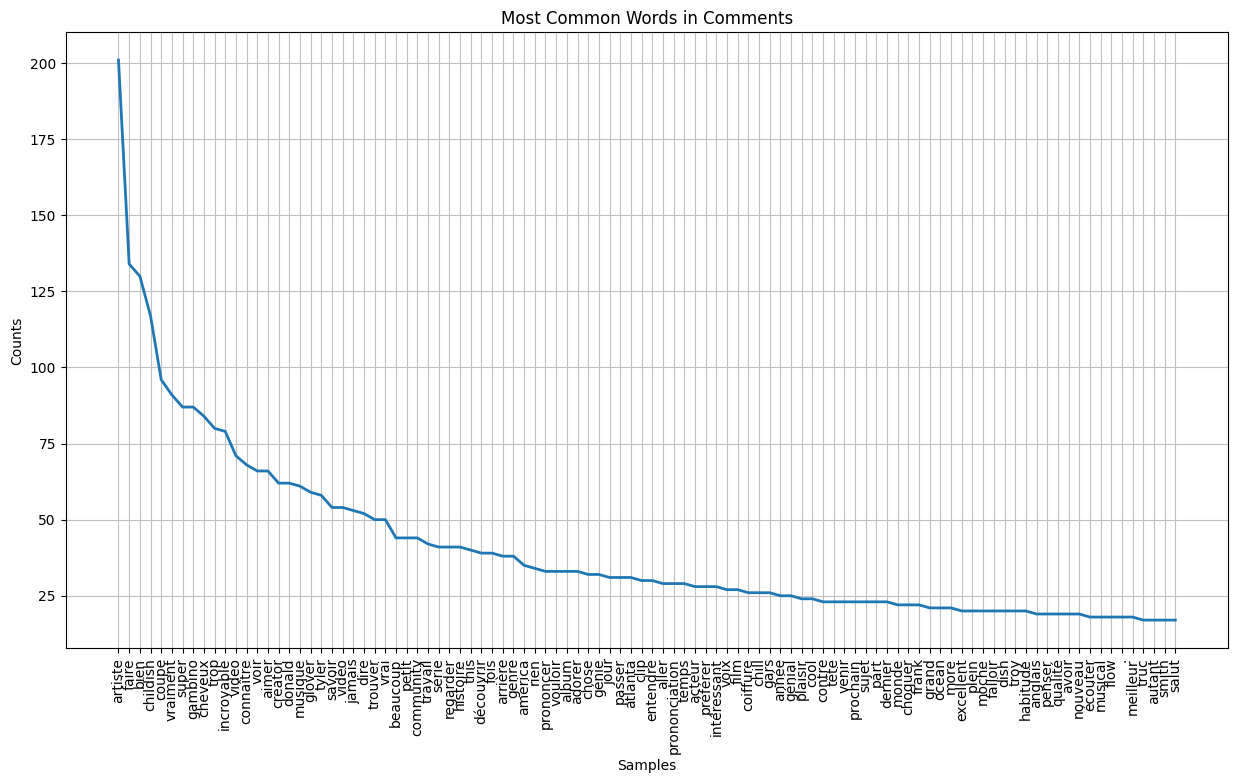

In [18]:
text = nltk.word_tokenize(' '.join(df['comment_clean_lem'].dropna()))
raw = nltk.Text(text)
fdistr = FreqDist(raw)
# freqDist ne fonctionne que sur des fichiers traités or c'est ce qu'on a fait avec le découpage en mot
# donc ça compte bien la fréquence des mots
# si on prend le fichier brut sans le couper en mots ça compte la fréquence de caractères
plt.figure(figsize=(15, 8))
fdistr.plot(100, cumulative=False, title='Most Common Words in Comments')

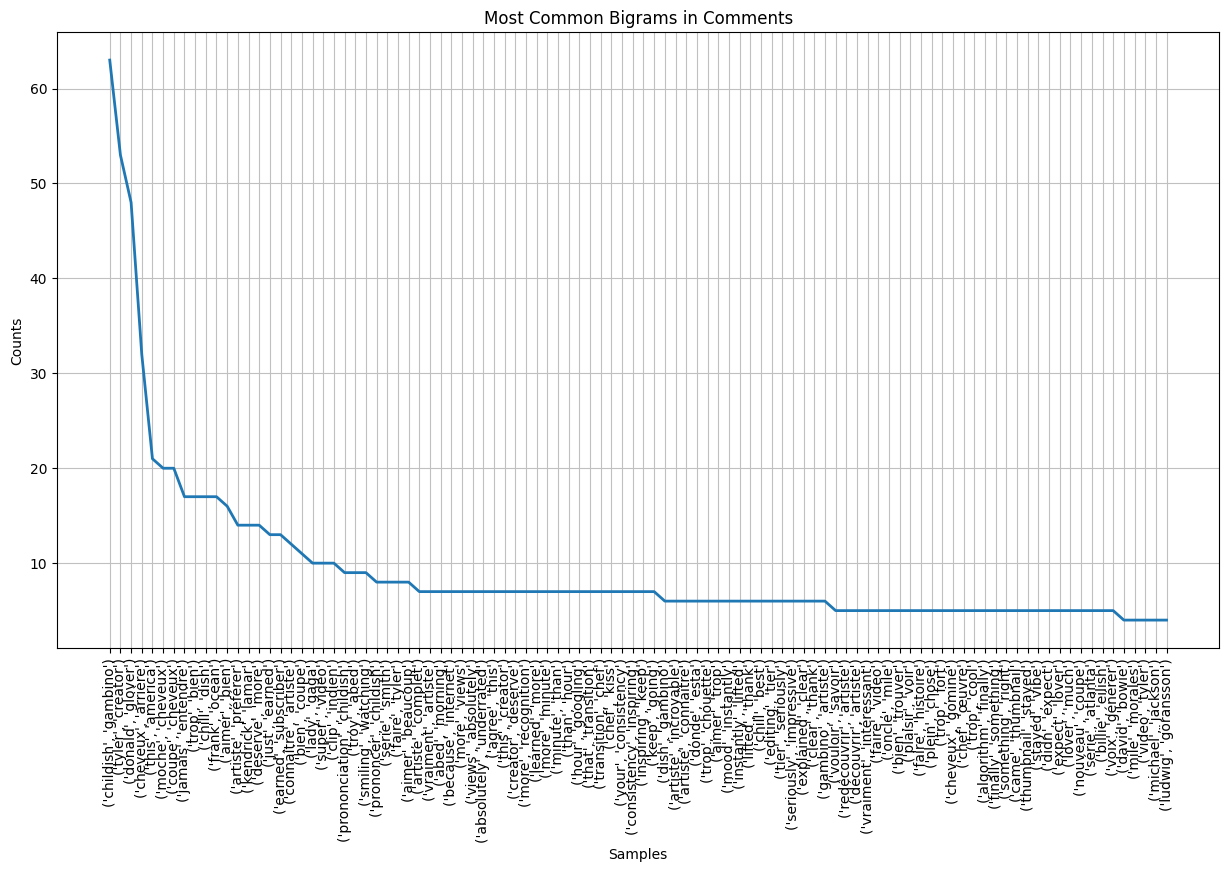

In [20]:
# afficher les bigrams les plus fréquents
from nltk import bigrams
bigrams_list = list(bigrams(text))
bigrams_freq = FreqDist(bigrams_list)
plt.figure(figsize=(15, 8))
bigrams_freq.plot(100, cumulative=False, title='Most Common Bigrams in Comments')
plt.show()



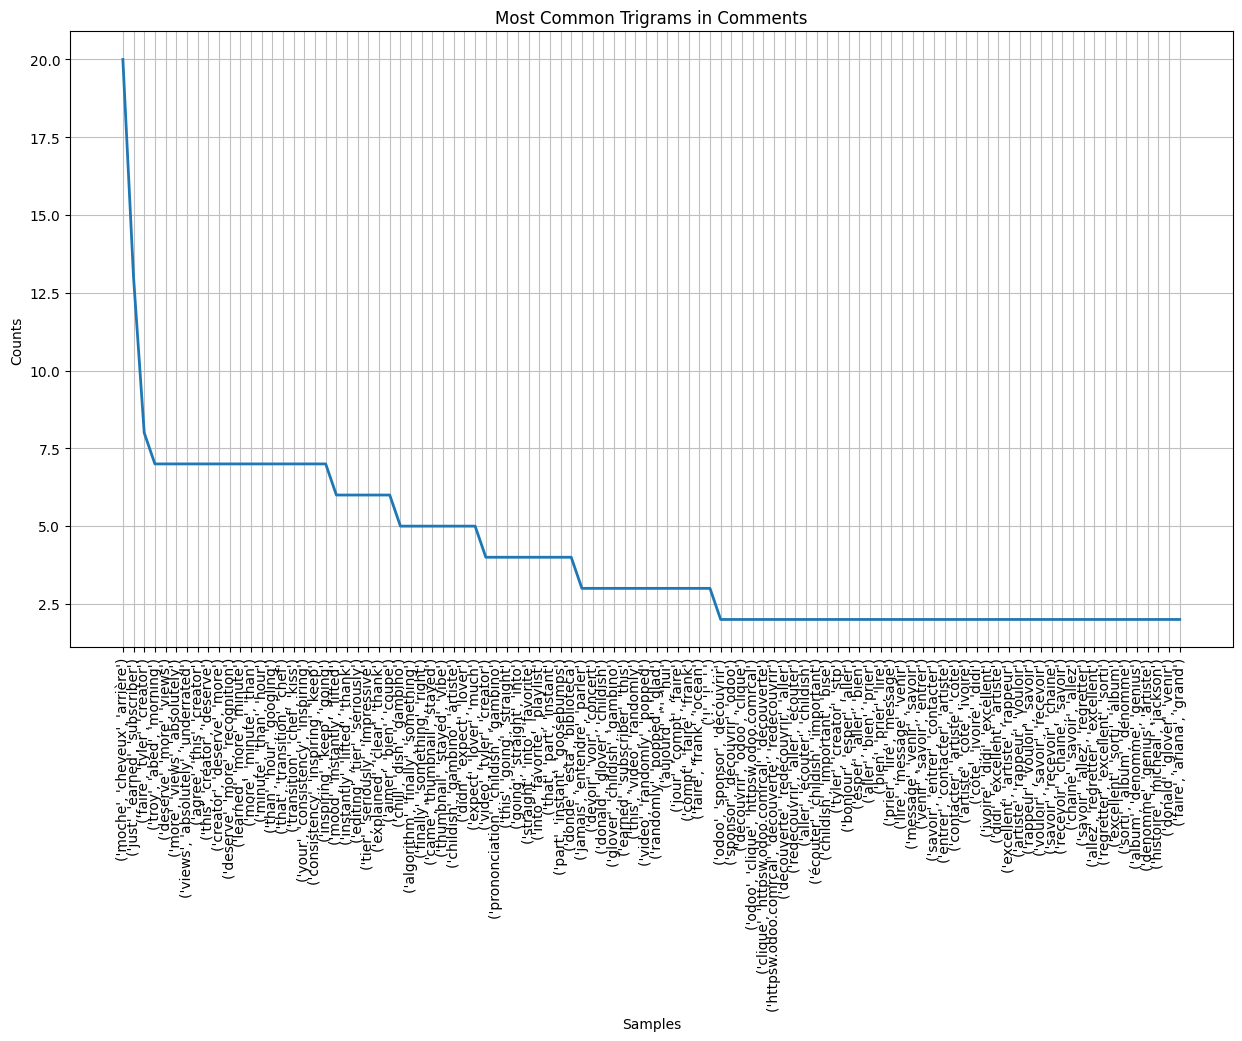

In [21]:
# afficher les trigrams les plus fréquents
from nltk import trigrams
trigrams_list = list(trigrams(text))
trigrams_freq = FreqDist(trigrams_list)
plt.figure(figsize=(15, 8))
trigrams_freq.plot(100, cumulative=False, title='Most Common Trigrams in Comments')
plt.show()

In [22]:
text.collocation_list()

AttributeError: 'list' object has no attribute 'collocation_list'

# Écriture du fichier

In [7]:
df.to_csv('database_clean.csv', index=False)